# Task 2: 3D Reconstruction [30]

**Please go through the notebook once before beginning working on it!**

In this notebook, we will extend our work from Task 1 to reconstruct a 3D model of a landmark using multiple images from the Heritage-Recon dataset.

<span style="color: red">**Submission Guidelines:**</span> Only one member of each group has to submit the file on LMS. The name of the file should be your group number. For example, if you are Group 1 then the file name should be **G01_Deliverable1.ipynb**. If you are unsure about your group number, then you can confirm it in the [sheet](https://docs.google.com/spreadsheets/d/1vN6JOLDWoFR5BnXTr0lMYGv_e9VzyAbqSUqf4VdjCQI/edit?gid=0#gid=0).

#### Imports

In [12]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.optimize import least_squares

# add imports here

### Dataset Loading & Preprocessing
Similar to what we did in Task 1, but instead of only a few images, we will now load in and preprocess all the images in our dataset

In [14]:
images_path = "../brandenburg_gate/brandenburg_gate/dense/SelectedImages"

image_files = sorted(os.listdir(images_path))

def is_image_file(filename):
    valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

valid_image_files = [file for file in image_files[2:] if is_image_file(file)]

In [15]:
def get_img_paths(folder_pth):
    """Returns a list containing filenames of all jpg files in folder_pth"""
    jpg_files = []

    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            filename = os.path.join(folder_pth, filename)
            jpg_files.append(filename)

    return jpg_files


def load_images(folder_pth):
    """Loads all images in folder_path"""
    images = []
    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_pth, filename))
            images.append(img)

    return images


def resize_image(img, size=(800, 600)):
    """Resizes image to a specified size."""
    return cv2.resize(img, size)


def convert_to_grayscale(img):
    """Converts an image to grayscale."""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def normalize_brightness(img):
    """Normalizes the brightness of an image using histogram equalization."""
    if len(img.shape) == 2:  
        return cv2.equalizeHist(img)
    elif len(img.shape) == 3:  
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

def preprocess_images(folder_pth, resize_dim=(800, 600)):
    """Loads, preprocesses, and returns images."""
    img_paths = get_img_paths(folder_pth)
    total_images = len(img_paths)
    preprocessed_images = []

    for i, path in enumerate(img_paths, start=1):
        img = cv2.imread(path)
        if img is not None:
            img = resize_image(img, size=resize_dim)  
            img = normalize_brightness(img) 
            img = convert_to_grayscale(img) 
            preprocessed_images.append(img)

        if i % 100 == 0 or i == total_images:
            print(f"Preprocessed {i}/{total_images} images")

    return preprocessed_images

Preprocessed 100/500 images
Preprocessed 200/500 images
Preprocessed 300/500 images
Preprocessed 400/500 images
Preprocessed 500/500 images


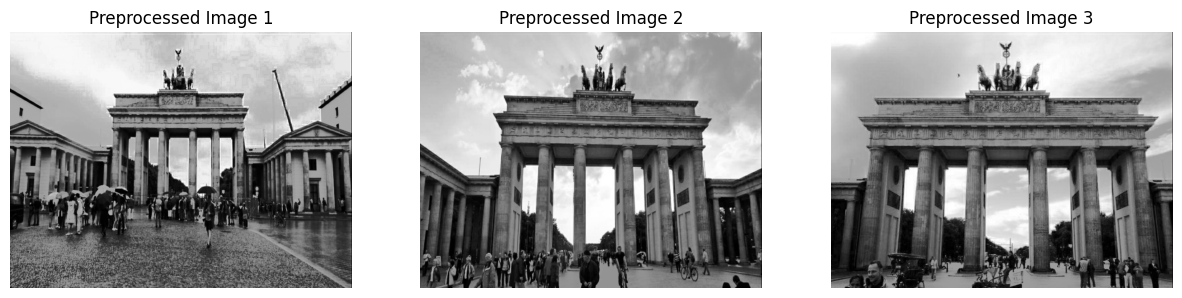

In [16]:
preprocessed_images = preprocess_images(images_path)

plt.figure(figsize=(15, 5))
for i, img in enumerate(preprocessed_images[:3]):  
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Preprocessed Image {i + 1}")
    plt.axis('off')
plt.show()

### Feature Detection & Matching (Across Multiple Images)
Extending what we did in Task 1, we will now extract the features from each image and match these features across all the images. However, this time you might want to consider extracting the best matches instead of all of them for each pair. Using the best matches improves the accuracy and reliability of our feature matching, which is crucial for the success of subsequent stages. Filtering out bad matches reduces the chance of errors propagating throughout the pipeline and results in a more robust and accurate 3D model.

Also display the results of feature detection and matching for any pair of images.

In [20]:
import cv2
import matplotlib.pyplot as plt

def feature_detection_and_matching(preprocessed_images, ratio_threshold=0.85):
    """
    Extracts features from all images, matches features across consecutive pairs (i, i+1),
    filters matches using Lowe's ratio test, and stores the results for further processing.

    Parameters:
        preprocessed_images (list): List of preprocessed images.
        ratio_threshold (float): Lowe's ratio threshold for filtering matches.

    Returns:
        keypoints_all (list): List of keypoints for all images.
        descriptors_all (list): List of descriptors for all images.
        matches_list (list): List of good matches for consecutive image pairs.
    """
    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Step 1: Detect features and compute descriptors for all images
    keypoints_all = []
    descriptors_all = []

    for image in preprocessed_images:
        kps, descs = orb.detectAndCompute(image, None)
        keypoints_all.append(kps)
        descriptors_all.append(descs)

    # Step 2: Match features for consecutive image pairs (i, i+1)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches_list = []

    for i in range(len(descriptors_all) - 1):
        desc1 = descriptors_all[i]
        desc2 = descriptors_all[i + 1]

        if desc1 is not None and desc2 is not None:
            # Use KNN matcher to get the two nearest neighbors
            knn_matches = bf.knnMatch(desc1, desc2, k=2)
            # Apply Lowe's ratio test
            good_matches = [m for m, n in knn_matches if m.distance < ratio_threshold * n.distance]
            matches_list.append(good_matches)
            print(f"Image Pair {i}-{i+1}: {len(good_matches)} good matches.")
        else:
            matches_list.append([])
            print(f"Image Pair {i}-{i+1}: No descriptors found.")

    return keypoints_all, descriptors_all, matches_list

def visualize_matches(preprocessed_images, keypoints_all, matches_list, pair_indices=(0, 1)):
    """
    Visualizes feature matching for a selected image pair.

    Parameters:
        preprocessed_images (list): List of preprocessed images.
        keypoints_all (list): List of keypoints for all images.
        matches_list (list): List of good matches for consecutive image pairs.
        pair_indices (tuple): Indices of the image pair to visualize.
    """
    i, j = pair_indices

    image1 = preprocessed_images[i]
    image2 = preprocessed_images[j]
    kp1 = keypoints_all[i]
    kp2 = keypoints_all[j]
    matches = matches_list[i]

    # Draw keypoints for the selected pair
    image1_color = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    image2_color = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)

    # Draw matches
    img_matches = cv2.drawMatches(
        image1_color, kp1, image2_color, kp2, matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Display the image with feature matching
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(f"Feature Matching Between Image {i+1} and Image {j+1}")
    plt.axis('off')
    plt.show()

Image Pair 0-1: 26 good matches.
Image Pair 1-2: 86 good matches.
Image Pair 2-3: 49 good matches.
Image Pair 3-4: 27 good matches.
Image Pair 4-5: 42 good matches.
Image Pair 5-6: 29 good matches.
Image Pair 6-7: 61 good matches.
Image Pair 7-8: 39 good matches.
Image Pair 8-9: 51 good matches.
Image Pair 9-10: 41 good matches.
Image Pair 10-11: 37 good matches.
Image Pair 11-12: 76 good matches.
Image Pair 12-13: 35 good matches.
Image Pair 13-14: 39 good matches.
Image Pair 14-15: 20 good matches.
Image Pair 15-16: 38 good matches.
Image Pair 16-17: 24 good matches.
Image Pair 17-18: 30 good matches.
Image Pair 18-19: 26 good matches.
Image Pair 19-20: 28 good matches.
Image Pair 20-21: 35 good matches.
Image Pair 21-22: 39 good matches.
Image Pair 22-23: 39 good matches.
Image Pair 23-24: 19 good matches.
Image Pair 24-25: 72 good matches.
Image Pair 25-26: 51 good matches.
Image Pair 26-27: 100 good matches.
Image Pair 27-28: 62 good matches.
Image Pair 28-29: 37 good matches.
Ima

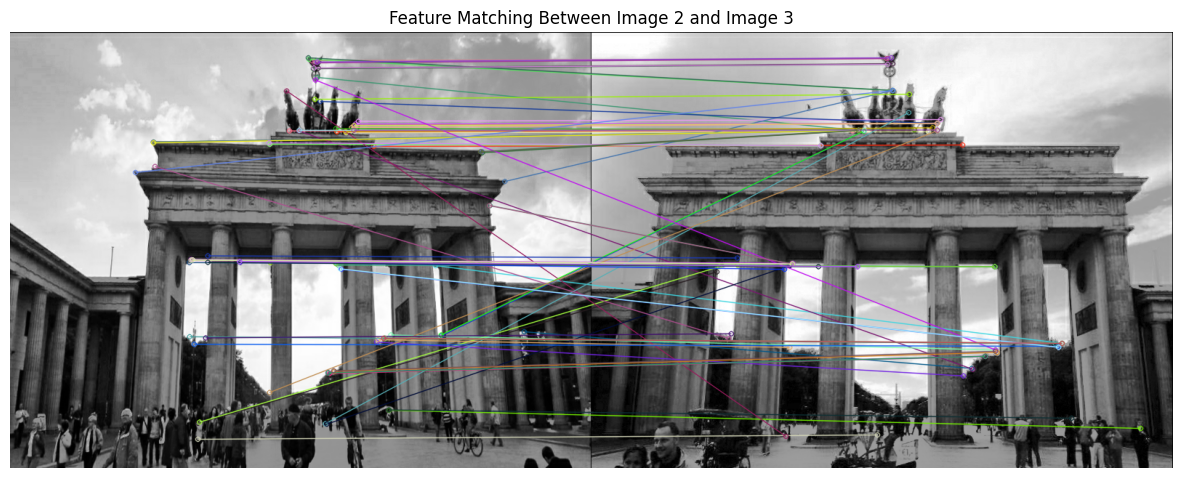

In [21]:
# Example Usage
# Assuming preprocessed_images is a list of preprocessed images
keypoints_all, descriptors_all, matches_list = feature_detection_and_matching(preprocessed_images)

# Visualize matches for a specific pair (e.g., pair 1 and 2)
visualize_matches(preprocessed_images, keypoints_all, matches_list, pair_indices=(1, 2))

### Camera Pose Estimation (Global)
We will estimate the relative camera poses (position and orientation) between consecutive image pairs. You can use the same technique as you did in Task 1 or switch to one of the others mentioned in the announcement on Slack.

In [23]:
import os
import numpy as np
import cv2
from colmap.scripts.python.read_write_model import read_cameras_binary, read_images_binary

# Paths to the COLMAP binary files and subset of images
camera_bin_path = "../brandenburg_gate/brandenburg_gate/neuralsfm/cameras.bin"
images_bin_path = "../brandenburg_gate/brandenburg_gate/neuralsfm/images.bin"
subset_image_dir = "../brandenburg_gate/brandenburg_gate/dense/SelectedImages/"

# Read cameras and images from COLMAP binary files
cameras = read_cameras_binary(camera_bin_path)
images = read_images_binary(images_bin_path)

# List all image filenames in the subset directory
subset_filenames = set(os.listdir(subset_image_dir))  # Filenames only
subset_filenames = {os.path.basename(f) for f in subset_filenames}  # Ensure base filenames

# Map to store K matrices for each image
K_matrices = {}

# Filter images to only those present in the subset
filtered_images = {img_id: image for img_id, image in images.items() if image.name in subset_filenames}

# Extract K matrices for the filtered images
for img_id, image in filtered_images.items():
    camera_id = image.camera_id
    camera = cameras[camera_id]
    params = camera.params
    fx, fy, cx, cy = params[:4]

    # Construct the intrinsic matrix (K)
    K = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0, 0, 1]
    ])
    K_matrices[image.name] = K

# Function to estimate relative camera pose using the dynamic K matrices
def estimate_camera_pose_dynamic(matches, kp1, kp2, K1, K2):
    """Estimates the relative camera pose between two images."""
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    # Compute the Fundamental Matrix
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
    
    # Compute the Essential Matrix
    E = K2.T @ F @ K1
    
    # Decompose the Essential Matrix to get R and T
    _, R, T, _ = cv2.recoverPose(E, pts1, pts2, K1)
    
    return R, T

# Use precomputed keypoints, descriptors, and matches
# keypoints_all, descriptors_all, matches_list are assumed to be precomputed

# Ensure keypoints_all and descriptors_all are dictionaries with image names as keys
keypoints_all = {name: kps for name, kps in zip(list(K_matrices.keys()), keypoints_all)}
descriptors_all = {name: desc for name, desc in zip(list(K_matrices.keys()), descriptors_all)}

# Updated pose estimation loop
global_poses = [np.eye(4)]  # First camera is at the origin

# Process each image pair
for i, image1_name in enumerate(list(K_matrices.keys())[:-1]):
    image2_name = list(K_matrices.keys())[i + 1]
    
    kp1, desc1 = keypoints_all[image1_name], descriptors_all[image1_name]
    kp2, desc2 = keypoints_all[image2_name], descriptors_all[image2_name]
    matches = matches_list[i]
    
    if matches:
        # Get dynamic K matrices
        K1 = K_matrices[image1_name]
        K2 = K_matrices[image2_name]
        
        # Estimate relative pose
        R, T = estimate_camera_pose_dynamic(matches, kp1, kp2, K1, K2)
        
        # Form the transformation matrix
        transformation = np.eye(4)
        transformation[:3, :3] = R
        transformation[:3, 3] = T[:, 0]
        
        # Compute the global pose
        global_pose = global_poses[-1] @ transformation
        global_poses.append(global_pose)
        
        print(f"Processed image pair: {image1_name} -> {image2_name}")
    else:
        print(f"Skipping pair: {image1_name}, {image2_name} due to missing matches.")

# Print global poses
for i, pose in enumerate(global_poses):
    print(f"Camera {i + 1} Global Pose:\n{pose}\n")

Processed image pair: 60841688_8298465546.jpg -> 60770994_853214983.jpg
Processed image pair: 60770994_853214983.jpg -> 60732645_2978928712.jpg
Processed image pair: 60732645_2978928712.jpg -> 60691378_320372293.jpg
Processed image pair: 60691378_320372293.jpg -> 60633305_3067485286.jpg
Processed image pair: 60633305_3067485286.jpg -> 60553649_2254779884.jpg
Processed image pair: 60553649_2254779884.jpg -> 60473547_4365702274.jpg
Processed image pair: 60473547_4365702274.jpg -> 60240609_7333978098.jpg
Processed image pair: 60240609_7333978098.jpg -> 60052444_281239788.jpg
Processed image pair: 60052444_281239788.jpg -> 59869733_4041190569.jpg
Processed image pair: 59869733_4041190569.jpg -> 59826471_8014732885.jpg
Processed image pair: 59826471_8014732885.jpg -> 59713287_6809504619.jpg
Processed image pair: 59713287_6809504619.jpg -> 59311169_8993668355.jpg
Processed image pair: 59311169_8993668355.jpg -> 59225698_5908834267.jpg
Processed image pair: 59225698_5908834267.jpg -> 59062671

### Choosing the technique
For this task, you have been given the choice of using either Structure from Motion (SfM) or Photogrammetry as your reconstruction method. A brief overview of the steps involved in each technique has been included in the handout provided to you. You can choose either technique for this task but before you choose one be sure to do a bit more research on each technique. I have also added some resources below to help you in understanding each technique.

[Understanding Structure From Motion Algorithms](https://medium.com/@loboateresa/understanding-structure-from-motion-algorithms-fc034875fd0c)\
[SfM](https://cmsc426.github.io/sfm/)\
[Chapter 13 - Structure from motion](https://mi.eng.cam.ac.uk/~cipolla/publications/contributionToEditedBook/2008-SFM-chapters.pdf)\
[What is Photogrammetry?](https://www.artec3d.com/learning-center/what-is-photogrammetry)\
[The Multi-View Environment](https://github.com/simonfuhrmann/mve)\
[open Multi-View Stereo](https://github.com/cdcseacave/openMVS)\
[Surface Reconstruction](https://www.open3d.org/docs/latest/tutorial/Advanced/surface_reconstruction.html)

**Technique chosen:**

### 3D Reconstruction
Once you have chosen the technique, you can now start working on actually 3D reconstruction. Depending on the technique, follow the pipeline to generate the 3D point cloud for your landmark.

Processing image pair 1/499...
  Triangulated 26 points for this pair.
Processing image pair 2/499...
  Triangulated 86 points for this pair.
Processing image pair 3/499...
  Triangulated 49 points for this pair.
Processing image pair 4/499...
  Triangulated 27 points for this pair.
Processing image pair 5/499...
  Triangulated 42 points for this pair.
Processing image pair 6/499...
  Triangulated 29 points for this pair.
Processing image pair 7/499...
  Triangulated 61 points for this pair.
Processing image pair 8/499...
  Triangulated 39 points for this pair.
Processing image pair 9/499...
  Triangulated 51 points for this pair.
Processing image pair 10/499...
  Triangulated 41 points for this pair.
Processing image pair 11/499...
  Triangulated 37 points for this pair.
Processing image pair 12/499...
  Triangulated 76 points for this pair.
Processing image pair 13/499...
  Triangulated 35 points for this pair.
Processing image pair 14/499...
  Triangulated 39 points for this pair.
P

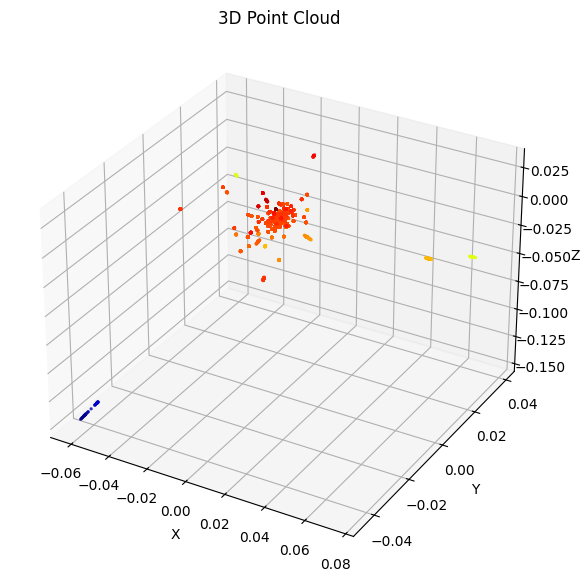

Image Pair 1: 26 matches
Image Pair 2: 86 matches
Image Pair 3: 49 matches
Image Pair 4: 27 matches
Image Pair 5: 42 matches
Image Pair 6: 29 matches
Image Pair 7: 61 matches
Image Pair 8: 39 matches
Image Pair 9: 51 matches
Image Pair 10: 41 matches
Image Pair 11: 37 matches
Image Pair 12: 76 matches
Image Pair 13: 35 matches
Image Pair 14: 39 matches
Image Pair 15: 20 matches
Image Pair 16: 38 matches
Image Pair 17: 24 matches
Image Pair 18: 30 matches
Image Pair 19: 26 matches
Image Pair 20: 28 matches
Image Pair 21: 35 matches
Image Pair 22: 39 matches
Image Pair 23: 39 matches
Image Pair 24: 19 matches
Image Pair 25: 72 matches
Image Pair 26: 51 matches
Image Pair 27: 100 matches
Image Pair 28: 62 matches
Image Pair 29: 37 matches
Image Pair 30: 40 matches
Image Pair 31: 76 matches
Image Pair 32: 45 matches
Image Pair 33: 30 matches
Image Pair 34: 48 matches
Image Pair 35: 55 matches
Image Pair 36: 38 matches
Image Pair 37: 36 matches
Image Pair 38: 32 matches
Image Pair 39: 41 ma

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def triangulate_points(matches, kp1, kp2, pose1, pose2, K1, K2):
    """
    Triangulates 3D points between two camera poses and matched keypoints.
    """
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Normalize points using intrinsic matrices
    pts1_normalized = cv2.undistortPoints(np.expand_dims(pts1, axis=1), K1, None)
    pts2_normalized = cv2.undistortPoints(np.expand_dims(pts2, axis=1), K2, None)

    # Build projection matrices
    proj_matrix1 = K1 @ pose1[:3]
    proj_matrix2 = K2 @ pose2[:3]

    # Triangulate points
    points_4d = cv2.triangulatePoints(proj_matrix1, proj_matrix2, pts1_normalized, pts2_normalized)
    points_3d = points_4d[:3] / points_4d[3]  # Convert to Euclidean
    return points_3d.T

def build_sparse_point_cloud(matches_list, keypoints_all, global_poses, K_matrices):
    """
    Builds a sparse 3D point cloud by triangulating points for all image pairs.
    """
    point_cloud = []
    for i in range(len(matches_list)):
        print(f"Processing image pair {i + 1}/{len(matches_list)}...")

        # Retrieve data for this pair
        image1_name = list(K_matrices.keys())[i]
        image2_name = list(K_matrices.keys())[i + 1]
        kp1, kp2 = keypoints_all[image1_name], keypoints_all[image2_name]
        matches = matches_list[i]

        pose1 = global_poses[i]
        pose2 = global_poses[i + 1]

        K1 = K_matrices[image1_name]
        K2 = K_matrices[image2_name]

        # Triangulate points for this pair
        points_3d = triangulate_points(matches, kp1, kp2, pose1, pose2, K1, K2)
        point_cloud.extend(points_3d)

        print(f"  Triangulated {len(points_3d)} points for this pair.")
    
    print(f"Total 3D points: {len(point_cloud)}")
    return np.array(point_cloud)

def visualize_point_cloud(points_3d):
    """
    Visualizes the 3D point cloud using Matplotlib.
    """
    print(f"Visualizing {len(points_3d)} 3D points...")
    
    # Normalize points for visualization
    points_3d = points_3d / np.linalg.norm(points_3d, axis=0).max()

    # 3D scatter plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    x = points_3d[:, 0]
    y = points_3d[:, 1]
    z = points_3d[:, 2]
    
    ax.scatter(x, y, z, s=2, c=z, cmap='jet', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Point Cloud')
    plt.show()

# Step 1: Generate the sparse point cloud
sparse_point_cloud = build_sparse_point_cloud(matches_list, keypoints_all, global_poses, K_matrices)

# Step 2: Visualize the point cloud
visualize_point_cloud(sparse_point_cloud)

# Step 3: Debug Matches and Poses
for i, matches in enumerate(matches_list):
    print(f"Image Pair {i + 1}: {len(matches)} matches")
for i, pose in enumerate(global_poses):
    print(f"Camera {i + 1} Pose:\n{pose}\n")

### Mesh Generation & Texturing
Convert the 3D points generated into a 3D mesh and apply textures to it. You can use techniques like Poisson Surface Reconstruction for creating the mesh. For texturing, project the images onto the mesh based on the camera poses.

In [ ]:
# your code here

### Visualization
Visualize the 3D model once you have generated it

In [25]:
# your code here
import open3d as o3d
import numpy as np

# Function for generating the mesh
def generate_mesh(points_3d):
    """Generate a 3D mesh using Poisson Surface Reconstruction."""
    print("Generating mesh from point cloud...")

    # Create a point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d)

    # Estimate normals for Poisson reconstruction
    print("Estimating normals...")
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    
    # Poisson Surface Reconstruction
    print("Performing Poisson surface reconstruction...")
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8)
    
    # Remove low-density triangles
    print("Cleaning up the mesh...")
    densities = np.asarray(densities)
    vertices_to_remove = densities < np.quantile(densities, 0.01)  # Remove bottom 1% density vertices
    mesh.remove_vertices_by_mask(vertices_to_remove)

    return mesh

# Function for visualizing the mesh
def visualize_mesh(mesh):
    """Visualize the generated 3D mesh."""
    print("Visualizing mesh...")
    mesh.compute_vertex_normals()  # Recompute normals for better shading
    o3d.visualization.draw_geometries(
        [mesh],
        window_name="3D Mesh Visualization",
        mesh_show_back_face=True  # Show back-facing triangles
    )

# Example Usage
# Assume `sparse_point_cloud` is already generated from your previous steps
print("Starting 3D mesh generation...")
mesh = generate_mesh(sparse_point_cloud)

print("Starting visualization...")
visualize_mesh(mesh)

Starting 3D mesh generation...
Generating mesh from point cloud...
Estimating normals...
Performing Poisson surface reconstruction...
Cleaning up the mesh...
Starting visualization...
Visualizing mesh...


### Save your model
Save the results from the 3D reconstruction process, which includes:

- The 3D point cloud data (sparse or dense depending on the method you used).
- The camera poses (rotation and translation matrices).
  
This step is essential for documenting and visualizing your results, and also for use in the final task. You can save the data in formats like .ply for point clouds or .obj for meshes, and save the matrices in standard formats like .npz (for NumPy arrays).

In [ ]:
# your code here

### Evaluation
Evaluate the quality of your model. You can talk about how successfully you were able to reconstruct the landmark including aspects such as geometry accuracy, completeness, and texture detail (An answer of 5-6 lines will suffice).

**ANS:**